# Importing libraries



In [1]:
# Install using pip
!pip install transformers seqeval[gpu]
!pip install sentencepiece
!pip install sentencepiec

# Import libraries
import re
import spacy
from spacy.tokens import Span
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification, AdamW
from nltk.corpus import wordnet as wn
import nltk
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertTokenizer, TFDistilBertForTokenClassification
from transformers import XLNetTokenizer, XLNetForTokenClassification
from seqeval.metrics import f1_score, accuracy_score

nltk.download('wordnet')
nltk.download('omw-1.4')

sp = spacy.load('en_core_web_sm')

# Select device
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 12.0 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 6.6 MB 27.1 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ac3e3597d625a59037a5ab808e5f14948a6164f34463639897d8e324b53b5214
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.1 MB/s 
Looking in indexes: ht

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


# Importing data

In [2]:
# File must be semi-colon separated. Expected columns:
#      question -> contains geo-analytical questions
#      type     -> contains 'Train' or 'Test'
# Important: 'Train' data must be on top and 'Test' data must follow
questions = pd.read_csv("data/questions.csv", sep=";").dropna()

# File must be semi-colon separated. Expected columns:
#      phrase   -> contains phrase to be categorised
#      tag      -> contains category
dictionary = pd.read_csv("data/dictionary.csv", sep=";").dropna()

# Data pre-processing

In [3]:
# Set words that should not be tagged
# This makes sure word 'states' in 'United States' is not tagged
cc_excluded_phrases = ["United States", "Tarrant County", "Ferry Building", "Twin Peaks", "New York City", "Loudoun County"]

# Checks if found occurrence is inside excluded phrase
def should_exclude(input_question_text, cc_occurrence):
  for cc_excluded_phrase in cc_excluded_phrases:
    for cc_excluded_phrase_occurrence in re.finditer(cc_excluded_phrase.lower().strip(), input_question_text.lower().strip()):
      if cc_excluded_phrase_occurrence.start() <= cc_occurrence.start() and cc_excluded_phrase_occurrence.end() >= cc_occurrence.end():
        return True
  return False

In [4]:
# Sort input on length (descending) to make sure longest phrases are tagged first
dictionary["length"] = dictionary["phrase"].str.len()
dictionary.sort_values("length", ascending=False, inplace=True)

# Create empty list
data = []

# Loop through all questions from question corpus
for index1, input_question in questions.iterrows():
  input_question_text = input_question["question"]

  # Get results from SpaCy
  pos_result = sp(input_question_text)

  # SpaCy creates default IOB tags, these are removed
  pos_result.ents = []

  # Loop through all core concepts
  for index2, cc_tags in dictionary.iterrows():
    for cc_occurrence in re.finditer(cc_tags["phrase"].lower().strip(), input_question_text.lower().strip()):

      # Skip if found occurrence is inside excluded phrase
      if should_exclude(input_question_text, cc_occurrence):
        continue

      # Add found result to ents if valid result
      if pos_result.char_span(cc_occurrence.start(), cc_occurrence.end(), label=cc_tags["tag"]) is not None:
        try:
          pos_result.ents = list(pos_result.ents) + [pos_result.char_span(cc_occurrence.start(), cc_occurrence.end(), label=cc_tags["tag"])]
        except:
          pass
          
  # Loop through all words and add results to list
  for word in pos_result:
    data.append([index1, word.text, word.pos_, "-".join(x for x in [word.ent_iob_, word.ent_type_] if x), input_question_text, input_question["type"]])

result = pd.DataFrame(data, columns=["sentence_number", "word", "word_pos", "word_tag", "sentence", "type"])

In [6]:
result[result["type"] == "Train"]['word_tag'].value_counts()

O           2960
B-OBJ        313
I-OBJ        196
B-EVE         66
I-CVAL        53
B-CVAL        46
B-PROPIR      45
I-FLDN        45
B-FLDN        43
I-EVE         42
B-CNAC        41
B-FLDR        34
I-FLDR        33
I-PROPIR      25
B-NETQR       25
I-NETQR       25
I-CNAC        17
I-OBJQR       13
B-OBJQR       12
B-EVEQO       10
I-OBJQB        7
B-OBJQB        7
I-CNAER        5
B-NET          5
B-OBJQI        4
I-CVAER        4
B-CNAER        4
B-CVAER        3
I-OBJQI        3
B-FLDI         3
I-FLDI         2
I-OBJQN        1
B-OBJQN        1
I-NET          1
I-EVEQO        1
B-EVEQR        1
B-FLDO         1
I-FLDO         1
Name: word_tag, dtype: int64

In [7]:
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                       s["word_pos"].values.tolist(),
                                                       s["word_tag"].values.tolist())]
    self.grouped = self.data.groupby("sentence_number").apply(agg_func)
    self.sentences = [s for s in self.grouped]

  def get_next(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None

getter = SentenceGetter(result)

# Set sentence and labels to list
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[2] for s in sentence] for sentence in getter.sentences]

# Add PAD tag and create id's of tags
tag_values = list(set(result["word_tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

# RoBERTa fine-tuning

In [8]:
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

tokenizer = None
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [9]:
def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []

  for word, label in zip(sentence, text_labels):

    # Tokenize the word and count # of subwords the word is broken into
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)

    # Add the tokenized word to the final tokenized word list
    tokenized_sentence.extend(tokenized_word)

    # Add the same label to the new list of labels `n_subwords` times
    labels.extend([label] * n_subwords)

  return tokenized_sentence, labels

tokenized_texts_and_labels = [
  tokenize_and_preserve_labels(sent, labs)
  for sent, labs in zip(sentences, labels)
]

# Tokenized texts and corresponding tags
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

# Maximum length of phrase is set to longest sentence
MAX_LEN = max([len(x) for x in tokenized_texts])
bs = 16

In [10]:
# PAD sentences up to maximum length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

# Set tags for padded parts
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

# Create attention mask (1 = actual words, 0 = PAD)
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

# Create tensors for training data (first n'th sentences)
tr_inputs = torch.tensor(input_ids[0:questions["type"].value_counts()[0]])
tr_tags = torch.tensor(tags[0:questions["type"].value_counts()[0]])
tr_masks = torch.tensor(attention_masks[0:questions["type"].value_counts()[0]])

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Create tensors for test data (last n'th sentences)
val_inputs = torch.tensor(input_ids[questions["type"].value_counts()[0]:questions.shape[0]])
val_tags = torch.tensor(tags[questions["type"].value_counts()[0]:questions.shape[0]])
val_masks = torch.tensor(attention_masks[questions["type"].value_counts()[0]:questions.shape[0]])

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [11]:
model = None
model = RobertaForTokenClassification.from_pretrained(
    'roberta-base',
    num_labels=len(tag2idx)
)

model.cuda();

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [12]:
# Set Adam parameters
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [13]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [14]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print(pred_tags)
    print(valid_tags)

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 1.348080837726593


Epoch:  33%|███▎      | 1/3 [00:02<00:05,  2.53s/it]

Validation loss: 0.6160277161333296
['PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O'

Epoch:  67%|██████▋   | 2/3 [00:04<00:02,  2.41s/it]

Validation loss: 0.5257547663317786
['PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'I-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'B-OBJ', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'O', 'O', 'B-OBJ', 'O', 'O', 'I-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'B-OBJ', 'I-

Epoch: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]

Validation loss: 0.5151239269309573
['PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'O', 'PAD', 'O', 'O', 'O', 'O', 'B-OBJ', 'O', 'O', 'B-OBJ', 'O', 'O', 'B-OBJ', 'B-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'O', 'O', 'B-OBJ', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAD', 'O', 'O', 'O', 'B-OBJ',

# Evaluation

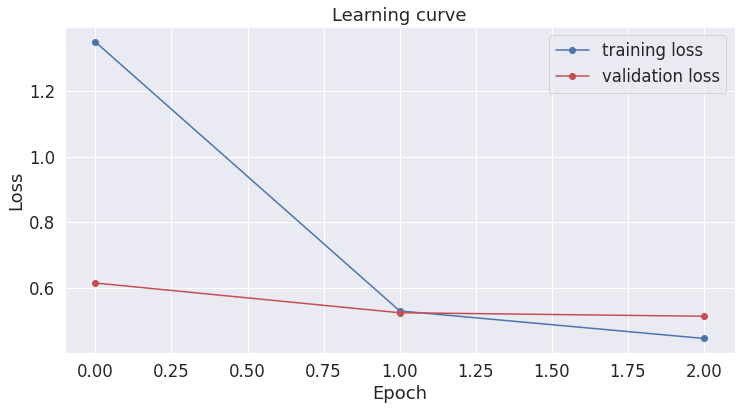

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [16]:
test_sentences = questions[questions["type"] == "Test"]["question"]

bert_data = []
confusion_matrix = []

for test_sentence in test_sentences:
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

   # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  count = 0
  for token, label_idx in zip(tokens, label_indices[0]):
    count += 1
    if not token.startswith("Ġ") and not token.startswith("<") and count != 2:
      new_tokens[-1] = new_tokens[-1] + token[0:]
    else:
      new_labels.append(tag_values[label_idx])
      new_tokens.append(token)

  for token, label in zip(new_tokens, new_labels):
    bert_data.append([label, token.replace("Ġ", "")])
  
  bert_result = pd.DataFrame(bert_data)
  bert_result.columns = ["label", "token"]
  bert_result = bert_result[(bert_result["token"] != "<s>") & (bert_result["token"] != "</s>")]
  
  merged_result = pd.merge(bert_result, result[result["sentence_number"] == questions[questions["question"] == test_sentence].index[0]], left_on = 'token', right_on = 'word')

  for index2, answer in merged_result.iterrows():
    if not [x for x in confusion_matrix if x[0] == answer["label"]]:
      confusion_matrix.append([answer["label"], 0, 0, 0])
    if not [x for x in confusion_matrix if x[0] == answer["word_tag"]]:
      confusion_matrix.append([answer["word_tag"], 0, 0, 0])
    
    for i in confusion_matrix:
      if i[0] == answer["label"]:
        # True Positive
        if answer["label"] == answer["word_tag"]:
          i[3] += 1
        
        # False Positive
        if answer["label"] != answer["word_tag"]:
          i[1] += 1
      
      if i[0] == answer["word_tag"]:
        # False Negative
        if answer["word_tag"] != answer["label"]:
          i[2] += 1

confusion_matrix_pd = pd.DataFrame(confusion_matrix, columns=["tag", "False Positive", "False Negative", "True Positive"])

In [17]:
confusion_matrix_pd["Precision"] = "N/A"
confusion_matrix_pd["Recall"] = "N/A"
confusion_matrix_pd["F1-score"] = "N/A"

for index, row in confusion_matrix_pd.iterrows():
  # Calculate Precision
  if row["True Positive"] != 0:
    confusion_matrix_pd.loc[index, "Precision"] = row["True Positive"] / (row["True Positive"] + row["False Positive"])

  # Calculate Recall
  if row["True Positive"] != 0:
    confusion_matrix_pd.loc[index, "Recall"] = row["True Positive"] / (row["True Positive"] + row["False Negative"])

  # Calculate F1-score
  if row["True Positive"] != 0:
    confusion_matrix_pd.loc[index, "F1-score"] = 2 * (confusion_matrix_pd.loc[index, "Precision"] * confusion_matrix_pd.loc[index, "Recall"]) / (confusion_matrix_pd.loc[index, "Precision"] + confusion_matrix_pd.loc[index, "Recall"])


confusion_matrix_pd.sort_values(by=['tag'], inplace=True)
confusion_matrix_pd

,tag,False Positive,False Negative,True Positive,Precision,Recall,F1-score
10,B-CNAC,0,89,0,N/A,N/A,N/A
17,B-CNAER,0,3,0,N/A,N/A,N/A
16,B-CVAER,0,47,0,N/A,N/A,N/A
19,B-CVAL,0,43,0,N/A,N/A,N/A
7,B-EVE,0,55,0,N/A,N/A,N/A
21,B-EVEQR,0,4,0,N/A,N/A,N/A
28,B-FLDI,0,1,0,N/A,N/A,N/A
5,B-FLDN,0,25,0,N/A,N/A,N/A
2,B-FLDR,0,37,0,N/A,N/A,N/A
13,B-LOC,0,10,0,N/A,N/A,N/A
